In [ ]:
%pip install grad-cam

In [13]:
import random
from tqdm import tqdm

In [2]:
import kagglehub
import os

# --- Celeb-DF v2 ---
celeb_df_path = kagglehub.dataset_download("reubensuju/celeb-df-v2")
print("Celeb-DF v2 path:", celeb_df_path)
print("Celeb-DF v2 folders:", os.listdir(celeb_df_path))

Celeb-DF v2 path: C:\Users\mujta\.cache\kagglehub\datasets\reubensuju\celeb-df-v2\versions\1
Celeb-DF v2 folders: ['Celeb-real', 'Celeb-synthesis', 'List_of_testing_videos.txt', 'YouTube-real']


In [3]:
# --- FaceForensics++ (Kaggle mirror) ---
ffpp_path = kagglehub.dataset_download("xdxd003/ff-c23")
print("FF++ path:", ffpp_path)
print("FF++ folders:", os.listdir(ffpp_path))

FF++ path: C:\Users\mujta\.cache\kagglehub\datasets\xdxd003\ff-c23\versions\1
FF++ folders: ['FaceForensics++_C23']


In [8]:
# Download VGGFace2 dataset
path_vgg = kagglehub.dataset_download("hearfool/vggface2")
print("VGGFace2 dataset path:", path_vgg)

100%|█████████████████████████████████████████████████████████████████████████████| 2.32G/2.32G [04:27<00:00, 9.33MB/s]

Extracting files...


VGGFace2 dataset path: C:\Users\mujta\.cache\kagglehub\datasets\hearfool\vggface2\versions\1


In [9]:
# Show the folder structure of Celeb DF
for root, dirs, files in os.walk(celeb_df_path):
    level = root.replace(ffpp_path, "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:10]:  # show only first 10 files per directory
        print(f"{subindent}{f}")
    if len(files) > 10:
        print(f"{subindent}... ({len(files)} files total)")

# Show the folder structure of FF++
for root, dirs, files in os.walk(ffpp_path):
    level = root.replace(ffpp_path, "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:10]:  # show only first 10 files per directory
        print(f"{subindent}{f}")
    if len(files) > 10:
        print(f"{subindent}... ({len(files)} files total)")

# Show the folder structure of VGGFace2
for root, dirs, files in os.walk(path_vgg):
    level = root.replace(ffpp_path, "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:10]:  # show only first 10 files per directory
        print(f"{subindent}{f}")
    if len(files) > 10:
        print(f"{subindent}... ({len(files)} files total)")

                                    1/
                                        List_of_testing_videos.txt
                                        Celeb-real/
                                            id0_0000.mp4
                                            id0_0001.mp4
                                            id0_0002.mp4
                                            id0_0003.mp4
                                            id0_0004.mp4
                                            id0_0005.mp4
                                            id0_0006.mp4
                                            id0_0007.mp4
                                            id0_0008.mp4
                                            id0_0009.mp4
                                            ... (590 files total)
                                        Celeb-synthesis/
                                            id0_id16_0000.mp4
                                            id0_id16_0001.mp4
                         

## PRE PROCESSING

In [6]:
import os
import cv2
import torch
from mtcnn import MTCNN
from torchvision import transforms
from PIL import Image

# Paths
CELEB_DF_PATH = r"C:\Users\mujta\.cache\kagglehub\datasets\reubensuju\celeb-df-v2\versions\1"
FFPP_PATH     = r"C:\Users\mujta\.cache\kagglehub\datasets\xdxd003\ff-c23\versions\1\FaceForensics++_C23"

# Output directory
OUTPUT_PATH = "processed_faces"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# MTCNN face detector
detector = MTCNN()

# Preprocessing
preprocess_tf = transforms.Compose([
    transforms.Resize((299, 299)),  # For Inception
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_faces_from_video(video_path, label, save_dir, frame_skip=30):
    cap = cv2.VideoCapture(video_path)
    frame_idx, saved = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            detections = detector.detect_faces(rgb)
            if len(detections) > 0:
                # largest face
                face = max(detections, key=lambda x: x['box'][2]*x['box'][3])
                x, y, w, h = face['box']
                margin = 0.2
                x1 = max(0, int(x - w*margin))
                y1 = max(0, int(y - h*margin))
                x2 = min(frame.shape[1], int(x + w*(1+margin)))
                y2 = min(frame.shape[0], int(y + h*(1+margin)))
                face_crop = rgb[y1:y2, x1:x2]
                if face_crop.size == 0:
                    continue
                pil_face = Image.fromarray(face_crop)
                face_tensor = preprocess_tf(pil_face)
                save_path = os.path.join(save_dir, f"{label}_{os.path.basename(video_path)}_{frame_idx}.pt")
                torch.save(face_tensor, save_path)
                saved += 1
        frame_idx += 1
    cap.release()
    return saved


### ---- Celeb-DF ----
real_dir = os.path.join(CELEB_DF_PATH, "Celeb-real")
fake_dir = os.path.join(CELEB_DF_PATH, "Celeb-synthesis")
yt_dir   = os.path.join(CELEB_DF_PATH, "YouTube-real")

save_real = os.path.join(OUTPUT_PATH, "real")
save_fake = os.path.join(OUTPUT_PATH, "fake")
os.makedirs(save_real, exist_ok=True)
os.makedirs(save_fake, exist_ok=True)

print("Extracting Celeb-DF faces...")
for video in os.listdir(real_dir):
    extract_faces_from_video(os.path.join(real_dir, video), "real", save_real)
for video in os.listdir(yt_dir):
    extract_faces_from_video(os.path.join(yt_dir, video), "real", save_real)
for video in os.listdir(fake_dir):
    extract_faces_from_video(os.path.join(fake_dir, video), "fake", save_fake)

### ---- FF++ ----
ff_dirs = {
    "real": os.path.join(FFPP_PATH, "original"),
    "fake": [
        os.path.join(FFPP_PATH, "Deepfakes"),
        os.path.join(FFPP_PATH, "Face2Face"),
        os.path.join(FFPP_PATH, "FaceShifter"),
        os.path.join(FFPP_PATH, "FaceSwap"),
        os.path.join(FFPP_PATH, "NeuralTextures"),
    ]
}

print("Extracting FF++ faces...")
# Real
for video in os.listdir(ff_dirs["real"]):
    extract_faces_from_video(os.path.join(ff_dirs["real"], video), "real", save_real)

# Fakes (multiple methods)
for fdir in ff_dirs["fake"]:
    for video in os.listdir(fdir):
        extract_faces_from_video(os.path.join(fdir, video), "fake", save_fake)

print("✅ Extraction finished!")


Extracting Celeb-DF faces...
Extracting FF++ faces...
✅ Extraction finished!


In [19]:
import os
import torch
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T

# Paths
vggface2_train_dir = r"C:\Users\mujta\.cache\kagglehub\datasets\hearfool\vggface2\versions\1\train"
real_dir = r"processed_faces\real"

# Current stats
existing_real = len([f for f in os.listdir(real_dir) if f.endswith('.pt')])
target_total = 94367  # equal to your fake count
need_to_add = max(0, target_total - existing_real)

print(f"Existing real images: {existing_real}")
print(f"Need to add {need_to_add} from VGGFace2 to balance with fakes.")

if need_to_add <= 0:
    print("✅ Already balanced.")
else:
    # Transform (same as before)
    transform = T.Compose([
        T.Resize((299, 299)),  # Match model input (Inception-based)
        T.ToTensor()
    ])

    added = 0
    failed = 0
    failed_log = open("failed_vggface2_images.txt", "w")

    # Iterate over all identities
    for person in os.listdir(vggface2_train_dir):
        person_path = os.path.join(vggface2_train_dir, person)
        if not os.path.isdir(person_path):
            continue

        for file in tqdm(os.listdir(person_path), desc=f"Converting {person}", leave=False):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            src = os.path.join(person_path, file)
            dest = os.path.join(real_dir, f"{person}_{file[:-4]}_vgg.pt")

            if os.path.exists(dest):
                continue

            try:
                img = Image.open(src).convert("RGB")
                tensor = transform(img)
                torch.save(tensor, dest)
                added += 1
            except Exception as e:
                failed += 1
                failed_log.write(f"{src} | {e}\n")

            if added >= need_to_add:
                break

        if added >= need_to_add:
            break

    failed_log.close()
    print(f"✅ Added {added} new real faces.")
    print(f"⚠️ Failed: {failed} images (see failed_vggface2_images.txt).")

# Final check
final_total = len([f for f in os.listdir(real_dir) if f.endswith('.pt')])
print(f"📊 Final total real images: {final_total}")

Existing real images: 33097
Need to add 61270 from VGGFace2 to balance with fakes.


✅ Added 61270 new real faces.
⚠️ Failed: 0 images (see failed_vggface2_images.txt).
📊 Final total real images: 94367


In [2]:
import os
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# Your folders
real_dir = r"sampled_faces\real"
fake_dir = r"sampled_faces\fake"

# Make output folders (optional)
os.makedirs(real_dir + "_jpg", exist_ok=True)
os.makedirs(fake_dir + "_jpg", exist_ok=True)

to_pil = transforms.ToPILImage()

def convert_pt_to_jpg(src_folder, dst_folder, delete_pt=False):
    files = [f for f in os.listdir(src_folder) if f.endswith(".pt")]
    for f in tqdm(files, desc=f"Converting {os.path.basename(src_folder)}"):
        src_path = os.path.join(src_folder, f)
        dst_path = os.path.join(dst_folder, os.path.splitext(f)[0] + ".jpg")

        try:
            tensor = torch.load(src_path)
            if len(tensor.shape) == 3 and tensor.shape[0] in [1,3]:
                img = to_pil(tensor)
                img.save(dst_path, "JPEG", quality=90)
                if delete_pt:
                    os.remove(src_path)
        except Exception as e:
            print(f"❌ Error converting {f}: {e}")

# Convert both
convert_pt_to_jpg(real_dir, real_dir + "_jpg", delete_pt=True)
convert_pt_to_jpg(fake_dir, fake_dir + "_jpg", delete_pt=True)

print("✅ Conversion complete!")


Converting fake: 100%|███████████████████████████████████████████████████████████| 20000/20000 [08:26<00:00, 39.45it/s]

✅ Conversion complete!


# BUILD DATASET AND AUGMENTATIONS

In [3]:
import torchvision.transforms as T

train_transforms = T.Compose([
    # ------------- Augmentation -------------
    T.RandomResizedCrop(299, scale=(0.8, 1.0)),   # Inception input 299×299
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    # JPEG compression simulation
    T.RandomApply([T.Lambda(lambda img: img.convert("RGB").save("tmp.jpg", "JPEG", quality=70) or Image.open("tmp.jpg"))], p=0.3),
    # ------------- To tensor -------------
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [4]:
import os, shutil, random
from tqdm import tqdm

real_dir = "sampled_faces/real"
fake_dir = "sampled_faces/fake"

base_out = "dataset"
splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(base_out, s, "real"), exist_ok=True)
    os.makedirs(os.path.join(base_out, s, "fake"), exist_ok=True)

def split_data(src_dir, label):
    files = [f for f in os.listdir(src_dir) if f.endswith(".jpg")]
    random.shuffle(files)
    n = len(files)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)

    for i, f in enumerate(tqdm(files, desc=label)):
        src = os.path.join(src_dir, f)
        if i < train_end:
            dst = os.path.join(base_out, "train", label, f)
        elif i < val_end:
            dst = os.path.join(base_out, "val", label, f)
        else:
            dst = os.path.join(base_out, "test", label, f)
        shutil.copy(src, dst)

split_data(real_dir, "real")
split_data(fake_dir, "fake")

print("✅ Dataset split into train/val/test")

fake: 100%|█████████████████████████████████████████████████████████████████████| 20000/20000 [03:18<00:00, 100.87it/s]

✅ Dataset split into train/val/test


In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

train_dataset = datasets.ImageFolder("dataset/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("dataset/val", transform=val_transforms)
test_dataset  = datasets.ImageFolder("dataset/test", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

from torchvision.models import inception_v3, Inception_V3_Weights

# load pretrained weights properly
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)

# disable auxiliary classifier manually (to avoid two outputs)
model.aux_logits = False

for param in model.parameters():
    param.requires_grad = False  # freeze base
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: real/fake
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

EPOCHS = 5
best_acc = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            _, preds = torch.max(out, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_inceptionv3.pth")

print("✅ Training complete. Best Val Acc = ", best_acc)


Using: cpu
Epoch 1/5 | Loss: 0.4514 | Val Acc: 0.8385
Epoch 2/5 | Loss: 0.4205 | Val Acc: 0.8475
Epoch 3/5 | Loss: 0.4167 | Val Acc: 0.8452
Epoch 4/5 | Loss: 0.4152 | Val Acc: 0.8393
Epoch 5/5 | Loss: 0.4178 | Val Acc: 0.8512
✅ Training complete. Best Val Acc =  0.85125


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds = torch.max(out, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("✅ Test Results:\n", classification_report(y_true, y_pred, target_names=["real", "fake"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


✅ Test Results:
               precision    recall  f1-score   support

        real       0.79      0.94      0.86      2000
        fake       0.92      0.76      0.83      2000

    accuracy                           0.85      4000
   macro avg       0.86      0.85      0.85      4000
weighted avg       0.86      0.85      0.85      4000

Confusion Matrix:
 [[1874  126]
 [ 485 1515]]


In [15]:
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cpu")

# Load model
# load pretrained weights properly
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)

# disable auxiliary classifier manually (to avoid two outputs)
model.aux_logits = False
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)
model.load_state_dict(torch.load("best_inceptionv3.pth", map_location=device))
model.to(device)
model.eval()

# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        grads = self.gradients
        acts = self.activations
        weights = torch.mean(grads, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * acts, dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy()

# choose target layer
target_layer = model.Mixed_7c
cam = GradCAM(model, target_layer)

# same transform as validation
val_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

def predict_with_heatmap(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = val_transforms(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    label = "Fake" if pred_class == 1 else "Real"

    # compute Grad-CAM
    model.zero_grad()
    output[0, pred_class].backward()
    heatmap = cam.generate()

    # overlay
    img_resized = img.resize((299, 299))
    heatmap = Image.fromarray(np.uint8(255 * heatmap)).resize(img_resized.size)
    heatmap = np.array(heatmap)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f"Prediction: {label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_resized)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

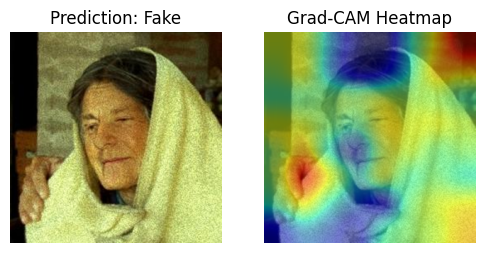

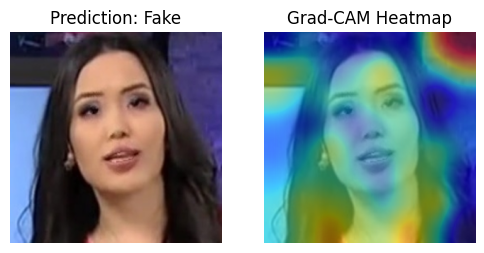

In [22]:
# Example test
predict_with_heatmap(r"C:\Users\mujta\OneDrive\Desktop\fake_0.jpg")


# Example test
predict_with_heatmap(r"C:\Users\mujta\OneDrive\Desktop\FaceSwap_1006.jpg")


## MODEL TRAINING

In [1]:
import torch, os, random, shutil
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

# Paths
real_dir = "sampled_faces/real"
fake_dir = "sampled_faces/fake"
output_root = "sampled_faces"

# Create subfolders
for split in ["train", "val", "test"]:
    for cls in ["real", "fake"]:
        os.makedirs(os.path.join(output_root, split, cls), exist_ok=True)

# Get all .pt paths
real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(".pt")]
fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(".pt")]

# Shuffle
random.shuffle(real_files)
random.shuffle(fake_files)

def split_data(files):
    n = len(files)
    train = files[:int(0.8*n)]
    val = files[int(0.8*n):int(0.9*n)]
    test = files[int(0.9*n):]
    return train, val, test

real_splits = split_data(real_files)
fake_splits = split_data(fake_files)

# Copy or link .pt files
def copy_split(files, split, cls):
    for src in tqdm(files, desc=f"{cls}-{split}"):
        dst = os.path.join(output_root, split, cls, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

for split_idx, split_name in enumerate(["train", "val", "test"]):
    copy_split(real_splits[split_idx], split_name, "real")
    copy_split(fake_splits[split_idx], split_name, "fake")

print("✅ Dataset split done.")


fake-test: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.73it/s]

✅ Dataset split done.


In [2]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x))], p=0.3),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.paths = []
        self.labels = []
        for label, cls in enumerate(["real", "fake"]):
            folder = os.path.join(root_dir, cls)
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.paths.append(os.path.join(folder, f))
                    self.labels.append(label)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        tensor = torch.load(self.paths[idx])  # shape: C,H,W
        img = transforms.ToPILImage()(tensor)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Build model
def build_inceptionv3(num_classes=2):
    model = models.inception_v3(weights="IMAGENET1K_V1")
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model

# Load data
train_ds = DeepfakeDataset("sampled_faces/train", train_transform)
val_ds   = DeepfakeDataset("sampled_faces/val", val_test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_inceptionv3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Training
best_acc = 0
for epoch in range(10):
    model.train()
    train_loss, train_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/10 [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (out.argmax(1) == labels).sum().item()
    train_acc = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_correct, val_loss = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/10 [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (out.argmax(1) == labels).sum().item()
    val_acc = val_correct / len(val_loader.dataset)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: TrainAcc={train_acc:.4f}, ValAcc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_inceptionv3.pth")

print("✅ Training complete! Best Val Acc:", best_acc)

Epoch 1/10 [Train]:   0%|                                                                     | 0/1000 [00:00<?, ?it/s]

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load test dataset
test_ds = DeepfakeDataset("dataset/test", val_test_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Load best model
model = build_inceptionv3()
model.load_state_dict(torch.load("best_inceptionv3.pth", map_location=device))
model.to(device)
model.eval()

# Predictions
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

# Metrics
print("✅ Test Accuracy:", (y_true == y_pred).mean())
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["real", "fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

In [ ]:
from torchvision import models
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.target_layer = target_layer
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
        self.activations = None

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        score = output[:, class_idx]
        score.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (299, 299))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Example: visualize heatmap for a deepfake image
model.eval()
gradcam = GradCAM(model, model.Mixed_7c)  # final inception block

def visualize_gradcam(image_path):
    tensor = torch.load(image_path).unsqueeze(0).to(device)
    img_pil = transforms.ToPILImage()(tensor.squeeze().cpu())
    input_tensor = val_test_transform(img_pil).unsqueeze(0).to(device)

    cam = gradcam.generate(input_tensor)
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(img_pil.resize((299, 299)))
    overlay = cv2.addWeighted(img_np, 0.6, cam, 0.4, 0)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

# Example usage:
# visualize_gradcam("dataset/test/fake/sample_123.pt")


In [ ]:
from PIL import Image

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = val_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img)
        prob = torch.softmax(out, dim=1)[0,1].item()
        label = "Fake" if prob > 0.5 else "Real"
    print(f"Prediction: {label} ({prob:.2f} probability of Fake)")
    return label, prob

# Example:
# predict_image("my_test_image.jpg")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
import os
from tqdm import tqdm

# ==============================
# 1️⃣ Dataset Loader (.pt)
# ==============================
class DeepfakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir):
        self.paths = []
        self.labels = []
        for folder, label in [(real_dir, 0), (fake_dir, 1)]:
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.paths.append(os.path.join(folder, f))
                    self.labels.append(label)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = torch.load(self.paths[idx])
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# ==============================
# 2️⃣ Load Full Dataset
# ==============================
real_dir = "sampled_faces/real"
fake_dir = "sampled_faces/fake"

full_dataset = DeepfakeDataset(real_dir, fake_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"✅ Dataset ready: {len(train_dataset)} train, {len(val_dataset)} val")

# ==============================
# 3️⃣ Model Setup (InceptionV3)
# ==============================
def build_inceptionv3(num_classes=2):
    model = models.inception_v3(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ==============================
# 4️⃣ Training Function
# ==============================
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, loss_sum / total

def train_inception(model, train_loader, val_loader, device, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_val_acc, patience, wait = 0, 3, 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/total:.4f} | Train Acc: {train_acc:.4f}")
        print(f"                 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_inceptionv3.pth")
            print("✅ Saved best model.")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("⏹️ Early stopping.")
                break

    print(f"🏁 Training complete. Best Val Acc: {best_val_acc:.4f}")

✅ Dataset ready: 32000 train, 8000 val


In [ ]:
# ==============================
# 5️⃣ Run Training
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_inceptionv3().to(device)
train_inception(model, train_loader, val_loader, device, epochs=20)

Epoch 1/20 [Train]:   0%|                                                                     | 0/1000 [00:00<?, ?it/s]

## EVALUATION AND TESTING

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load model ----
def build_inceptionv3(num_classes=2):
    model = models.inception_v3(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = build_inceptionv3().to(device)
model.load_state_dict(torch.load("best_inceptionv3.pth", map_location=device))
model.eval()

# ---- Evaluate ----
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("✅ Evaluation done!")

In [ ]:
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Real", "Pred Fake"],
            yticklabels=["True Real", "True Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve – Inception V3")
plt.show()

print(f"ROC AUC Score: {auc_score:.4f}")

In [ ]:
from PIL import Image
from torchvision import transforms

# Match training preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred = torch.argmax(probs).item()

    label = "REAL ✅" if pred == 0 else "FAKE 🚫"
    print(f"{img_path} → {label} (Fake prob = {probs[1]:.4f})")

# Run prediction
predict_image("test_images/real_sample.jpg")
predict_image("test_images/spoof_sample.jpg")

# HEAT MAP

In [ ]:
import torch
import numpy as np
import cv2
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load your trained model ----
def build_inceptionv3(num_classes=2):
    model = models.inception_v3(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

model = build_inceptionv3().to(device)
model.load_state_dict(torch.load("best_inceptionv3.pth", map_location=device))
model.eval()

# ---- Choose target layer (final conv block) ----
target_layers = [model.Mixed_7c]

# ---- Transform (same as during training) ----
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---- Grad-CAM Function ----
def generate_heatmap(image_path, label_names=["Real", "Fake"]):
    img = Image.open(image_path).convert("RGB")
    rgb_img = np.array(img) / 255.0
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
    targets = [ClassifierOutputTarget(1)]  # Target class: Fake

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap (Fake regions)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Example ----
generate_heatmap("test_images/spoof_sample.jpg")